In [44]:
import sys
sys.path.append("src/")

import pandas as pd
import numpy as np
import tensorflow as tf

import os 

cwd = os.getcwd()
os.chdir("../src")
import tensorflow_utils as tf_utils
import utils as utils
from dataset_manager import DataSetManager

os.chdir(cwd)


/home/acevedo/Desktop/Current_GAN/MicrobiotaGAN/src/utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/acevedo/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/acevedo/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/acevedo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/acevedo/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/acevedo/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    sel

In [45]:
config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )

sess = tf.Session(config=config)

In [46]:
a = tf.constant(2)
b = tf.constant(3)

c = sess.run(a+b)
print(c)
sess.close()

5


In [47]:

DIM = 512  # model dimensionality
GEN_DIM = 100  # output dimension of the generator
DIS_DIM = 1  # outptu dimension fo the discriminator
FIXED_GENERATOR = False  # wheter to hold the generator fixed at ral data plus Gaussian noise, as in the plots in the paper
LAMBDA = .1  # smaller lambda makes things faster for toy tasks, but isn't necessary if you increase CRITIC_ITERS enough
BATCH_SIZE = 256   # batch size
ITERS = 10000 #100000 # how many generator iterations to train for
FREQ = 250  # sample frequency




CRITIC_ITERS = 5  # homw many critic iteractions per generator iteration


def Generator_Softmax(n_samples,  name='gen'):

    with tf.variable_scope(name):
        noise = tf.random_normal([n_samples, GEN_DIM])
        output01 = tf_utils.linear(noise, DIM, name='fc-1')
        output01 = tf_utils.relu(output01, name='relu-1')
        
        output02 = tf_utils.linear(output01, DIM, name='fc-2')
        output02 = tf_utils.relu(output02, name='relu-2')
        
        output03 = tf_utils.linear(output02, DIM, name='fc-3')
        output03 = tf_utils.relu(output03, name='relu-3')
        
        output04 = tf_utils.linear(output03, GEN_DIM, name='fc-4')

        # Reminder: a logit can be modeled as a linear function of the predictors
        output05 = tf.nn.softmax(output04, name = 'softmax-1')

        
        return output05
        

def Discriminator(inputs, is_reuse=True, name='disc'):
    with tf.variable_scope(name, reuse=is_reuse):
        print('is_reuse: {}'.format(is_reuse))
        output01 = tf_utils.linear(inputs, DIM, name='fc-1')
        output01 = tf_utils.relu(output01, name='relu-1')

        output02 = tf_utils.linear(output01, DIM, name='fc-2')
        output02 = tf_utils.relu(output02, name='relu-2')

        output03 = tf_utils.linear(output02, DIM, name='fc-3')
        output03 = tf_utils.relu(output03, name='relu-3')

        output04 = tf_utils.linear(output03, DIS_DIM, name='fc-4')
        
        return output04
    
real_data = tf.placeholder(tf.float32, shape=[None, GEN_DIM])
fake_data = Generator_Softmax(BATCH_SIZE)

disc_real = Discriminator(real_data, is_reuse=False)
disc_fake = Discriminator(fake_data)

disc_cost = tf.reduce_mean(disc_fake) - tf.reduce_mean(disc_real)
gen_cost = - tf.reduce_mean(disc_fake)

# WGAN gradient penalty parameters

alpha = tf.random_uniform(shape=[BATCH_SIZE, 1], minval=0., maxval=1.)
interpolates = alpha*real_data + (1.-alpha) * fake_data
disc_interpolates = Discriminator(interpolates)
gradients = tf.gradients(disc_interpolates, [interpolates][0])
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
gradient_penalty = tf.reduce_mean((slopes - 1)**2)

disc_cost += LAMBDA * gradient_penalty
    
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='disc')
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='gen')


gen/fc-1/add   [256, 512]
gen/fc-2/add   [256, 512]
gen/fc-3/add   [256, 512]
gen/fc-4/add   [256, 100]
is_reuse: False
disc/fc-1/add   [None, 512]
disc/fc-2/add   [None, 512]
disc/fc-3/add   [None, 512]
disc/fc-4/add   [None, 1]
is_reuse: True
disc_1/fc-1/add   [256, 512]
disc_1/fc-2/add   [256, 512]
disc_1/fc-3/add   [256, 512]
disc_1/fc-4/add   [256, 1]
is_reuse: True
disc_2/fc-1/add   [256, 512]
disc_2/fc-2/add   [256, 512]
disc_2/fc-3/add   [256, 512]
disc_2/fc-4/add   [256, 1]


# Traning Operations

In [49]:

# Use place holders for the learning rate
#WGAN Training operations

lr_value = tf.placeholder(tf.float32, shape=()) # 1e-4

disc_train_op = tf.train.AdamOptimizer(learning_rate=gan_lr, beta1=0.5, beta2=0.9).minimize(disc_cost, var_list=disc_vars)

if len(gen_vars) > 0:
    gen_train_op = tf.train.AdamOptimizer(learning_rate=gan_lr, beta1=0.5, beta2=0.9).minimize(gen_cost, var_list=gen_vars)
else:
    gen_train_op = tf.no_op()


In [50]:
partiton_n = pd.read_csv('random_amounts.csv', header=None).values.flatten()
train_set =  pd.read_csv('../data/experiment_march_21/train_set.csv', header=None).values

np.random.seed(42)
indices = np.random.randint(0,train_set.shape[0], size=partiton_n[0]).tolist()
print(np.sum(indices))


my_ds = DataSetManager(train_set[indices])


556624454


# Triangualr CLR

In [ ]:
cycle = np.floor(1+iterations/(2*step_size))
x = np.abs(iterations/step_size - 2*cycle + 1)
lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))

In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from clr import CyclicLR
import numpy as np

/home/acevedo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [36]:
pasos = 20000

magic_lr = CyclicLR(base_lr=0.01, max_lr=0.05, step_size=pasos)

In [37]:
def train_step(clr_object):
    current_lr = clr_object.clr()
    # Sess run training operation
    clr_object.on_batch_end()
    return current_lr

In [65]:
record_lr = np.array([ train_step(magic_lr) for k in range(4*pasos)])

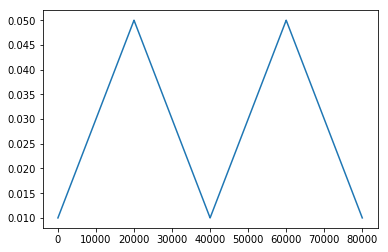

In [66]:
plt.plot(record_lr)

# GAN Trainin Loop

In [62]:
desired_epochs = 1000

iters_per_epoch = my_ds.num_examples/BATCH_SIZE
total_iters = np.ceil(desired_epochs*iters_per_epoch)

print(total_iters)

63254.0


In [ ]:
ITERS = total_iters
magic_lr2 = CyclicLR(base_lr=0.01, max_lr=0.05, step_size=pasos)
# Train loop
with tf.Session() as sess:

    #
    # DUCT TAPE SOLUTION
    # iter_ = 0

    """
    while my_ds.epochs_completed < desired_epochs:
        iter_ +=1    
    """
    for iter_ in range(ITERS):
        current_lr = magic_lr2.clr()
        
        batch_data, disc_cost_ = None, None

        previous_epoch =  my_ds.epochs_completed 

        # train critic
        for i_ in range(CRITIC_ITERS):
            batch_data =  my_ds.next_batch(BATCH_SIZE) # data_gen.__next__()
            disc_cost_, _ = sess.run([disc_cost, disc_train_op], feed_dict={real_data: batch_data})

        # train generator
        sess.run(gen_train_op)   

        gen_cost2 = sess.run(gen_cost)   

        current_epoch =  my_ds.epochs_completed 

        condition2 = current_epoch % 5 == 0
        if current_epoch > previous_epoch and condition2:
            disc_loss_record.append(disc_cost_)
            gen_loss_record.append(gen_cost2)
            epoch_record.append(my_ds.epochs_completed ) 
            # print("Diff "+str(current_epoch - previous_epoch))

        if (np.mod(iter_, FREQ) == 0) or (iter_+1 == ITERS):

            """
            print("===> Debugging")
            print(disc_loss_record)
            print(gen_loss_record)
            """

            bot.loss_hist.append(disc_cost_)

            fake_samples = sess.run(fake_data) # , feed_dict={real_data: batch_data}
            # print("\n==> Sum-Simplex condition: " +str(np.sum(fake_samples, axis=1))) 
            send_bot_message(bot,my_ds, iter_, ITERS, identifier)

            session_saver.save(sess, model_path)
            save_history(storing_path, gen_loss_record,disc_loss_record,epoch_record, my_ds,iter_, epochs, global_iters )

            k = my_ds.epochs_completed
            # save_gen_samples(fake_data, disc_fake ,sess, storing_path, k) # fake_data = Generator_Softmax(BATCH_SIZE)


        utils.tick()  #  _iter[0] += 1

    if iter_ == ITERS:
        session_saver.save(sess, model_path)

# LR Finder function

In [ ]:
def find_lr(session, cost_operation, optimize_operation, init_value = 1e-8, final_value=10., beta = 0.98):
    num = len(trn_loader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for data in trn_loader:
        batch_num += 1
        #As before, get the loss for this mini-batch of inputs/outputs
        inputs,labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.data[0]
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        #Do the SGD step
        loss.backward()
        optimizer.step()
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses